# PROJECT 3
## Solving a partial differential equation

In [277]:
#imports
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import matplotlib 
matplotlib.rcParams['text.usetex']=True
import matplotlib.pyplot as plt
from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.animation import FuncAnimation

#newer imports
from random import random, seed
from sklearn.linear_model import SGDRegressor
import seaborn as sns

# Calculates value of Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# Creates design matrix
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

# Calculates R²-score
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

# Calculates mean squared error
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def analytical_solution(x, t): 
    return np.sin(np.pi*x)*np.exp(-(np.pi**2)*t)

def plot_imshow(data, extent_vec, colours, fsize, figure_name, colourbar_label): 
	fig = plt.figure()
	axes = plt.gca()
	mynorm = matplotlib.cm.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
	img = axes.imshow(data, extent=extent_vec, cmap=plt.get_cmap(colours), norm=mynorm)
	plt.xlabel(r'x, $1/L$', fontsize=fsize)
	plt.ylabel(r't, $L^2/\pi^2$', fontsize=fsize)
	plt.xticks(fontsize=fsize)
	plt.yticks(fontsize=fsize)
	cbar = fig.colorbar(img, ax=axes)
	cbar.set_label(colourbar_label, fontsize=fsize)
	cbar.ax.tick_params(labelsize=fsize)
	plt.savefig(figure_name, format="pdf")

## The heat equation
The heat equation can be mathematically written as 
$$
\frac{\partial^2 u}{\partial x^2} = \frac{\partial u}{\partial t}
$$
where $x\in[0,L]$ and $t\geq 0$. Setting $L=1$ and using the forward Euler method
$$
u^{n+1}_i = u_i^n + \frac{\Delta t}{\Delta x^2}[u_{i+1}^n-2u_i^n+u_{i-1}^n], 
$$
which has an error of order $\mathcal{O}(\Delta x^2)$, and is stable as long as $\frac{\Delta t}{\Delta x^2}\leq 1/2$.

In [278]:
# Initiating solver
class NumericalSolver: 
    def __init__(self, N, dt, T):
        self.N_ = N
        self.T_ = T
        self.dx = 1.0/(self.N_-1)
        self.dt = dt
        self.Nt_ = int(self.T_/self.dt)+1
        self.u_ = np.zeros((self.N_, self.Nt_))
        self.dtdx2 = self.dt/(self.dx*self.dx)
        if (self.dtdx2>0.5): 
            print("The Euler method is unstable with these step sizes. Decrease the time step size.")
            print("Alternatively, use the Crank-Nicholson solver.")
        
        self.add_initial_conditions()
    
    
    def add_initial_conditions(self): 
        for i in range(self.N_): 
            self.u_[i, 0] = np.sin(np.pi*i*self.dx)
        
    def forward_euler(self, it): 
        for i in range(1, self.N_-1): 
            self.u_[i, it+1] = self.u_[i, it] + self.dtdx2*(self.u_[i+1, it]-2.0*self.u_[i,it]+self.u_[i-1,it])
            
    def prepare_crank_nicholson(self): 
        self.A = np.zeros((self.N_-2, self.N_-2))
        self.B = np.zeros((self.N_-2, self.N_-2))
        r = 0.5*self.dtdx2
        for i in range(0, self.N_-2, 1): 
                self.A[i,i]= 1.0 + 2.0*r
                self.B[i,i]= 1.0 - 2.0*r
        for i in range(1, self.N_-2, 1): 
                self.A[i, i-1] = -r
                self.A[i-1, i] = -r
                self.B[i, i-1] = r
                self.B[i-1, i] = r
        
                
    def crank_nicholson(self, it): 
        u_internal = self.u_[1:self.N_-1, it]
        b_tmp = self.B @ u_internal
        self.u_[1:self.N_-1, it+1] = np.linalg.inv(self.A)@b_tmp
    
    def CN_solve(self): 
        print("Solving using the Crank-Nicholson method.")
        self.prepare_crank_nicholson()
        i = 0
        while (i*self.dt<self.T_): 
            self.crank_nicholson(i)
            i += 1
        
        
    def solve(self):
        print("Solving using the forward Euler method.")
        i = 0
        while (i*self.dt<self.T_): 
            self.forward_euler(i)
            i += 1          


# Animation, $\Delta x = 1/10$ #

In [ ]:
solver = NumericalSolver(11, 0.005, 1.0)
solver.solve()

dt = solver.dt
u = solver.u_
N, Nt = u.shape
x_vals = np.linspace(0,1.0, N)
fsize=15

fig, ax = plt.subplots()
ln, = plt.plot(x_vals, u[:, 0] , label="Heat gradient")
plt.xlabel("x", fontsize=fsize)
plt.ylabel("u", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)

time_txt = plt.text(0.27, 0.95, "t = {:.3e}".format(0), color="black", 
                    horizontalalignment="right", verticalalignment="top", fontsize=fsize)

def update(frame):
    ln.set_data(x_vals, u[:, frame])
    current_time = frame*dt
    time_txt.set_text("t = {:.3e}".format(current_time))
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(0, Nt, 1),
                    repeat=False, blit=0)
ani.save("heat01.gif", writer="ffmpeg", fps=24)
plt.show()

# $\Delta x = 1/10 $

Solving using the forward Euler method.


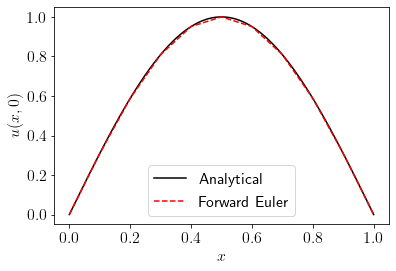

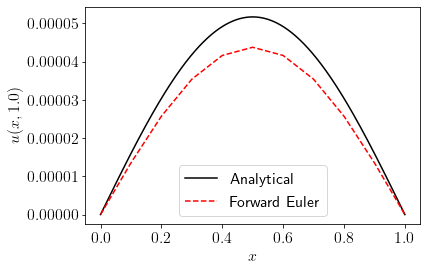

In [287]:
solver = NumericalSolver(11, 0.005, 1.0)
solver.solve()

dt = solver.dt
u = solver.u_

x = np.linspace(0, 1.0, 1001)
t = np.linspace(0, 1.0, 1001)

NORMAL = 16
fig, ax = plt.subplots(figsize = (6, 4))
plt.plot(x,analytical_solution(x,0),'k-',label='Analytical')
plt.plot(x_vals, u[:, 0] , 'r--', label='Forward Euler'); 
plt.xlabel(r'$x$', fontsize=NORMAL); plt.ylabel(r'$u(x,{:.0f})$'.format(dt*0), fontsize=NORMAL)
plt.xticks(fontsize=NORMAL); plt.yticks(fontsize=NORMAL)
plt.legend(fontsize=NORMAL); plt.savefig("euler_delta1_.{:.0f}.pdf".format(dt*0), bbox_inches='tight'); plt.show()

fig, ax = plt.subplots(figsize = (6, 4))
plt.plot(x,analytical_solution(x,1.0),'k-',label='Analytical')
plt.plot(x_vals, u[:, u.shape[1]-1] , 'r--', label='Forward Euler');
plt.xlabel(r'$x$', fontsize=NORMAL); plt.ylabel(r'$u(x,{:.1f})$'.format(1), fontsize=NORMAL)
plt.xticks(fontsize=NORMAL); plt.yticks(fontsize=NORMAL)
plt.legend(fontsize=NORMAL); plt.savefig("euler_delta1_.{:.1f}.pdf".format(1), bbox_inches='tight'); plt.show()

Solving using the forward Euler method.


C:\Users\Derya\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


max abs error:  0.006163504616922555


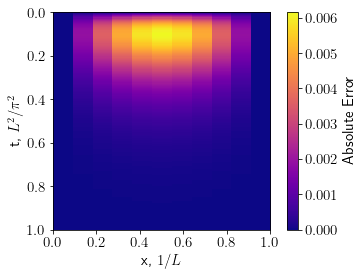

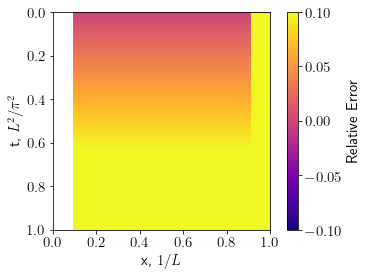

In [293]:
N = 11
dt = 0.005
T = 1.0
nt = int(T/dt)+1 #number of time points

x = np.linspace(0, 1.0, N)
t = np.linspace(0, T, nt)

analytical = np.zeros((N,nt))

solver = NumericalSolver(N, dt, T)
solver.solve()
u = solver.u_

for i in range(len(t)):
    analytical[:,i] = analytical_solution(x,t[i])

abs_error = abs(u - analytical)
rel_error = abs(u - analytical) / abs(analytical)
     
 
plot_imshow(abs_error.T, [0, 1.0, 1.0, 0], "plasma", 15, "absolute_error_delta1.pdf", "Absolute Error")
plot_imshow(rel_error.T, [0, 1.0, 1.0, 0], "plasma", 15, "relative_error_delta1.pdf", "Relative Error")

print('max abs error: ', abs_error.ravel()[np.argmax(abs_error)])

# $\Delta x = 1/100$ #

Solving using the forward Euler method.


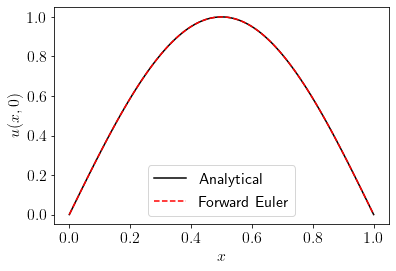

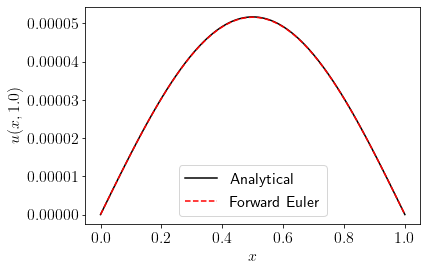

In [300]:
solver = NumericalSolver(101, 5e-5, 1.0)
solver.solve()

dt = solver.dt
u = solver.u_
N, Nt = u.shape
nt = int(T/dt)+1 #number of time points

x = np.linspace(0, 1, N)
t = np.linspace(0, 1.0, nt)

NORMAL = 16
fig, ax = plt.subplots(figsize = (6, 4))
plt.plot(x,analytical_solution(x,0),'k-',label='Analytical')
plt.plot(x, u[:, 0] , 'r--', label='Forward Euler'); 
plt.xlabel(r'$x$', fontsize=NORMAL); plt.ylabel(r'$u(x,{:.0f})$'.format(dt*0), fontsize=NORMAL)
plt.xticks(fontsize=NORMAL); plt.yticks(fontsize=NORMAL)
plt.legend(fontsize=NORMAL); plt.savefig("euler_delta2_.{:.0f}.pdf".format(dt*0), bbox_inches='tight'); plt.show()

fig, ax = plt.subplots(figsize = (6, 4))
plt.plot(x,analytical_solution(x,1.0),'k-',label='Analytical')
plt.plot(x, u[:, u.shape[1]-1] , 'r--', label='Forward Euler');
plt.xlabel(r'$x$', fontsize=NORMAL); plt.ylabel(r'$u(x,{:.1f})$'.format(1), fontsize=NORMAL)
plt.xticks(fontsize=NORMAL); plt.yticks(fontsize=NORMAL)
plt.legend(fontsize=NORMAL); plt.savefig("euler_delta2_.{:.1f}.pdf".format(1), bbox_inches='tight'); plt.show()

Solving using the forward Euler method.


C:\Users\Derya\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


max abs error:  6.052469419354223e-05


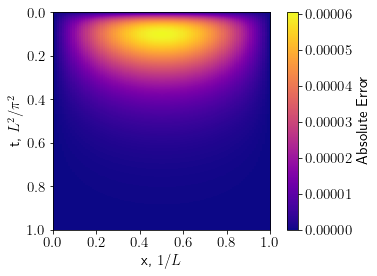

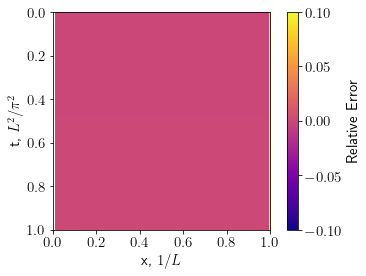

In [301]:
N = 101
dt = 5e-5
T = 1.0
nt = int(T/dt)+1 #number of time points

x = np.linspace(0, 1, N)
t = np.linspace(0, T, nt)

analytical = np.zeros((N,nt))

solver = NumericalSolver(N, dt, T)
solver.solve()
u = solver.u_

for i in range(len(t)):
    analytical[:,i] = analytical_solution(x,t[i])

abs_error = abs(u - analytical)
rel_error = abs(u - analytical) / abs(analytical)
     
plot_imshow(abs_error.T, [0, 1.0, 1.0, 0], "plasma", 15, "absolute_error_delta2.pdf", "Absolute Error")
plot_imshow(rel_error.T, [0, 1.0, 1.0, 0], "plasma", 15, "relative_error_delta2.pdf", "Relative Error")

print('max abs error: ', abs_error.ravel()[np.argmax(abs_error)])

### General solutions to coefficients in analytical solution

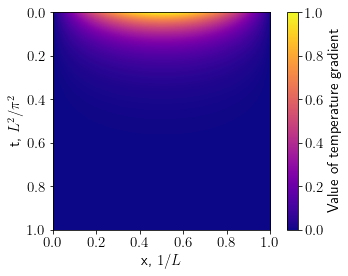

In [290]:
x = np.linspace(0, 1.0, 1001)
t = np.linspace(0, 1.0, 1001)
mx, mt = np.meshgrid(x,t)
z = analytical_solution(mx,mt)
plot_imshow(z, [0, 1.0, 1.0, 0], "plasma", 15, "analytical_solution.pdf", "Value of temperature gradient")